In [1]:
import os
os.environ["PYSPARK_PYTHON"] = r"C:\Users\krish\anaconda3\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\krish\anaconda3\python.exe"

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
                    .appName("GBK Vs RBK") \
                    .master("local[*]") \
                    .getOrCreate()

In [4]:
spark

In [ ]:
customer_rdd = spark.sparkContext.textFile('../Data/Customer Data.csv')

In [6]:
customer_rdd.count()

169674

In [7]:
header = customer_rdd.first()
header

'customer_id,name,city,state,country,registration_date,is_active'

In [8]:
cleaned_rdd = customer_rdd.filter(lambda row: row != header).map(lambda row: row.split(','))

In [10]:
cleaned_rdd.take(3)

[['0', 'Customer_0', 'Pune', 'West Bengal', 'India', '2023-10-10', 'True'],
 ['1', 'Customer_1', 'Bangalore', 'Gujarat', 'India', '2023-10-19', 'False'],
 ['2', 'Customer_2', 'Bangalore', 'Karnataka', 'India', '2023-02-10', 'True']]

### Reduce By Key

In [11]:
unique_cities = cleaned_rdd.map(lambda row: (row[2], 1)).reduceByKey(lambda x, y: x + y)

In [12]:
unique_cities.collect()

[('Pune', 21481),
 ('Hyderabad', 21174),
 ('Delhi', 21123),
 ('Mumbai', 21041),
 ('Bangalore', 21272),
 ('Ahmedabad', 21272),
 ('Chennai', 21046),
 ('Kolkata', 21264)]

### Group By Key

In [13]:
grouped_by_key_rdd = cleaned_rdd.map(lambda row: (row[2], 1)).groupByKey()
grouped_by_key_rdd.take(3)

[('Pune', <pyspark.resultiterable.ResultIterable at 0x24a8c310110>),
 ('Hyderabad', <pyspark.resultiterable.ResultIterable at 0x24afeafb090>),
 ('Delhi', <pyspark.resultiterable.ResultIterable at 0x24a8c311050>)]

In [14]:
grouped_by_key_result = grouped_by_key_rdd.map(lambda row: (row[0], len(row[1])))
grouped_by_key_result.collect()

[('Pune', 21481),
 ('Hyderabad', 21174),
 ('Delhi', 21123),
 ('Mumbai', 21041),
 ('Bangalore', 21272),
 ('Ahmedabad', 21272),
 ('Chennai', 21046),
 ('Kolkata', 21264)]

### ReduceByKey:
- Combines values locally on each partition before shuffling.
- Less data movement over the network.
- More efficient and scalable.
- Used for aggregations like sum, count, max, etc.

### GroupByKey:
- Moves all values for a key across the cluster before grouping.
- Can cause network congestion and memory issues with large datasets.
- Use only when actual grouping is needed (e.g., collecting lists).

Both reduceByKey and groupByKey can be used to count how many times each city appears. However, reduceByKey is more efficient, because it reduces the data before shuffling. In contrast, groupByKey first moves all values with the same key to one place and then processes them, which is slower and uses more memory. That's why reduceByKey is preferred for aggregations.

While groupByKey is less efficient than reduceByKey for aggregations, it does have valid use cases—especially when you actually need access to all the values associated with each key, not just a summary like sum or count.

#### Use groupByKey when:
- You need to preserve all values per key (not reduce them).
- You need to perform a non-commutative, non-associative operation (i.e., the order of values matters).
- You're preparing data for complex downstream processing or formatting.

#### Examples Where groupByKey Makes Sense
1. Collect All Orders Per Customer
- Suppose you have an RDD of (customer_id, order_amount) and you want to collect all order amounts per customer.
```
  rdd = sc.parallelize([
        ("cust1", 100), ("cust1", 200),
        ("cust2", 300), ("cust2", 150)
    ])
    
    grouped = rdd.groupByKey()
    result = grouped.mapValues(list).collect()
  # Output: [("cust1", [100, 200]), ("cust2", [300, 150])]
```

2. Joining or Grouping for Further Processing
- In a machine learning pipeline, you might group user events by user ID to extract features, click sequences, or time-series input.
```
events_rdd = sc.parallelize([
    ("user1", "click"), ("user1", "scroll"),
    ("user2", "click"), ("user2", "purchase")
])

user_events = events_rdd.groupByKey().mapValues(list)
# Output: [("user1", ["click", "scroll"]), ("user2", ["click", "purchase"])]

```

#### Caution with groupByKey
Even when valid, use it only when necessary, and watch for performance hits with large keys or large value lists. If you're not sure, always ask: "Do I need all the values, or just a summary?"

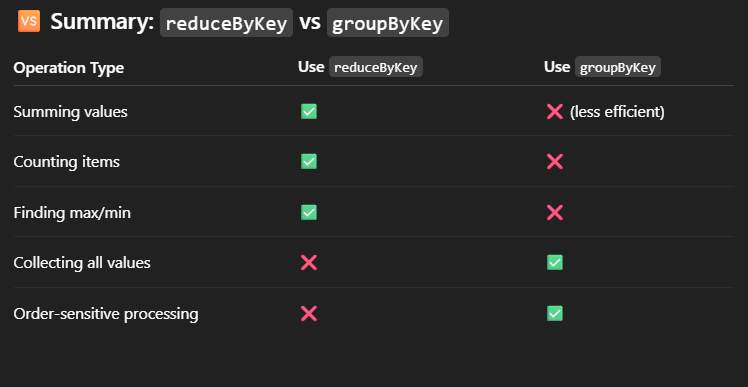